## Outline

Title : **Powerful image recognition with transfer learning**

Goal:

* learn how to use a variety of pretrained models. We will get good performance from using a sophisticated model. 
* The goal is NOT hyperparameter optimization. we will do educated guess and explain them. 
* The goal is NOT to compare the different pre-trained models, but to show how they can be used practically. 

Outline: 

* Introduction 
* What is transfer learning? 
* Running this tutorial 
* Initialisation 
* VGG16
* VGG19
* ResNet50
* Saving the model
* Evaluating the model and studying the results
* Conclusion

**TODO**  
* compress photo

## Running this tutorial 

To run this tutorial, you will need: 

* a Linux or Windows PC with a GPU. 
* specific python packages for deep learning (Keras, TensorFlow) and to analyze the results (numpy, matplotlib)
* the dogs and cats dataset. 

If you want to set this up, please refer to the instructions in my first post [Image Recognition: Dogs vs Cats! (92%)](https://thedatafrog.com/dogs-vs-cats/).

When, you're done, specify in the cell below the location of the dataset directory, which the one that contains the `dogs` and `cats` subdirectories. Then, execute the cell to import the required packages. 

In [1]:
# define and move to dataset directory
datasetdir = '/data2/cbernet/maldives/dogs_vs_cats'
import os
os.chdir(datasetdir)

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

## A couple tools

We're going to start by defining two functions that we will need later. 

The first function, `generators`, returns two image iterators that we will use to produce batches of images for the training and the validation of our neural networks. 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 30

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('dogs','cats'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('dogs','cats'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset
    

The functions has two parameters, `shape` and `preprocessing`, which depend on the pre-trained model in use. 

For instance, the various models have been trained on images with different shapes: 

* (224,224,3) for VGG16, VGG19, and ResNet50, so images with three color channels and 224x224 pixels.
* (299,299,3) for InceptionV3. 

The iterators load the dog and cat images from the disk and convert these images to arrays with the given `shape`. If the shape is wrong, the images will not be adapted to the model, and the code will crash. So we'll have to be careful to choose the correct shape for each pre-trained model we're going to use. 

The iterators are created by a keras `ImageDataGenerator` that does the following: 

* it has a 50% chance to flip left and right in the image. This provides basic data augmentation without much cost in terms of computing. Indeed, the flipping is easily carried out under the hood by numpy in a very efficient way.  
* then it applies the `preprocessing` function to the image. This function should be adapted to the pre-trained model in use, and is passed to the `generators` function as an argument. Indeed, in python, a function is an object, that can happily be passed around to other functions).  
* it keeps 90% of the images for training, reserving 10% of the images for validation. Since we have about 25 000 images in our dataset in total, this leaves 2500 images for a rather accurate validation (more on this later).


The second function will be used to plot the accuracy and loss as a function of the epoch, so that we can see how the training worked. To get a feeling for overfitting, these quantities will be plotted for both the training and validation datasets: 

In [3]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

We're now ready to get started with our first pre-trained model.

##  VGG16

The first VGG models were created by Karen Simonyan and Andrew Zisserman, and first presented in the paper [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556) in 2015. VGG16 is the 2016 version of the VGG model, and VGG19 is the 2019 version.  

At the time, VGG models really came as a breakthrough, for a number of reasons. First, the authors were able to outperform the competition by a large amount on the Image Net Large-Scale Visual Recognition Challenge (ILSVRC). Then, they showed that, with transfer learning, their models generalize well to other image recognition tasks on smaller datasets (see Appendix B in the paper), achieving state-of-the art performance on these datasets as well. Finally, they made their best-performing networks available to the public for further research and practical applications. 

Surprisingly enough, the VGG architecture is quite straightforward and very similar to the original convolutional networks. The main idea behind VGG was to make the network deeper by stacking more convolutional layers. And this was made possible by restricting the size of the convolutional windows to only 3x3 pixels. 

### Feature extraction with VGG16

So let's have a look at the VGG16 architecture. For this, we create an instance of the VGG16 model with keras, and we print the summary: 

In [33]:
vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(weights='imagenet')
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

The first part of the model, which I'll call the convolutional part in the following, is made of five blocks of stacked convolutional layers, followed by a max pooling layer. This part produces a tensor of shape (7,7,512) for each input image (see the output of the `block5_pool` layer). 

The first two dimensions, (7,7), are aligned with the dimensions of the original image, and we can think of this as a very coarse version of the image, with only 7x7=49 large pixels. But for each pixel, instead of having 3 color channels, we have 512 features that describe what the network is seeing in this pixel (and also around it). 

This tensor therefore contains 7x7x512 = 25 088 numbers that are the features extracted by the network for the image. 

But what exactly are these "features"? 

In my post about [Real Time Human Detection with OpenCV](https://thedatafrog.com/human-detection-video/) we have used a clever (and fairly complicated) algorithm, the Histograms of Oriented Gradients (HOG), to extract the image features (basically the lines and flat surfaces in the image). These features are then interpreted by a Support Vector Machine (SVM) to decide whether there is a human in the detection window or not. 

Here, and generally speaking in deep learning, we instead let the network discover the features by itself during the training! No need to design and code a complicated feature extraction algorithm, we just give the network a structure with enough flexibility, and we train it by examples. 

Think of a baby. 

![](DSC_3435.jpg)
*1 day, can already see*

I don't know much about the human brain nor human vision, and have only limited experience with babies! (got two.) Anyway here is what I think. Take it as an analogy, maybe it's right, maybe it's wrong, but I find it interesting. 

During the very first hours of its life, the baby has to learn how to see. And by that I mean to make sense of the overwhelming signal streams that come from her eyes. I suspect that at first, the baby learns how to see lines, by connecting the information from neighbouring retina rods and cones. Then, she starts seeing shapes, and recognizing objects. This is some kind of an unsupervised learning process: you just need to move your eyes to see that things are connected, no need to be shown examples. And much, much later, the baby will be able to use supervised learning: cat! she says. No, this is a tiger. 


VGG16, as we downloaded it, was trained on the large ImageNet dataset and is already able to see. 
But it has also been trained to classify the images in the 1000 categories of ImageNet. 

The classification occurs in the second part of the model, which takes the image features in input and picks a category. As we can see in the model summary,

```
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 1000)              4097000  
```

this part is made of: 

* a Flatten layer that turns the (7,7,512) feature tensor into a 1D array of size 7x7x512 = 25088; 
* two hidden Dense layers with 4096 neurons each;
* a Dense layer with 1000 neurons, one for each category. The softmax activation function is used for these neurons, so that the 1000 values they spit out sum up to unity, and can be considered as probabilities. 

But our task is to classify dog and cat pictures, so we have only two categories. 

What can we do? With keras, it's easy to import only the convolutional part of VGG16, by setting the `include_top` parameter to `False`: 

In [34]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False)
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

You can check in the summary that the classifier has indeed been removed. 

The convolutional model can already be used to extract the features for a given image: 

In [35]:
del x
from keras.preprocessing import image

img_path = 'dogs/dog.1.jpg'

# loading the image: 
img = image.load_img(img_path, target_size=(224, 224))
# turn it into a numpy array
x = image.img_to_array(img)
print(np.min(x), np.max(x))
print(x.shape)
# expand the shape of the array, 
# a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)
print(xs.shape)
# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)
# evaluate the model to extract the features
features = conv_model.predict(xs)
print(features.shape)

0.0 255.0
(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 512)


Let's take a closer look at this code. 

The first important thing to note is that the `predict` method of our model is designed to work on several images. These images are supposed to be stored in a `numpy` array with shape `(n,224,224,3)`, 
where `n` is the number of images to be processed. So first, we have loaded an image, and converted it to a numpy array of shape `(224,224,3)`. To match the signature of the `predict` method, we then created an array of shape `(1,224,224,3)` with `np.expand_dims`. 

The other important point is that VGG16 has been trained on pre-processed images. Quoting the VGG paper: 

*"The only processing we do is subtracting the mean RGB value, computed on the training set, from each pixel"*

To reach maximum performance, it is important to apply the exact same preprocessing before evaluating the network. Keras advocates the use of `vgg16.preprocess_inputs` for this, so that's what we're going to do. 

You may print the feature tensor if you wish, but that's not going to tell you much. This is really just a (big) bunch of numbers. To make sense of these numbers, we need to create our own classifier. 

One possibility could be to store the features in data arrays for each image. Then, we could train a small neural network on these arrays. This approach would be perfectly viable. However, that's not what we're going to do. Instead, we will extend VGG16 with our own classifier. This solution is easier to implement and is also more flexible.

### Custom classification with VGG16

In the [Keras documentation for VGG16](https://keras.io/applications/#vgg16), and also in the original paper, we see that the input of VGG16 should be images with 224x224 pixels. And we also know that the images have to be preprocessed in the correct way for this model. 
So we create training and validation iterators to produce such images, with the function we have defined at the beginning of this post:  

In [36]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg16.preprocess_input)

Found 22481 images belonging to 2 classes.
Found 2496 images belonging to 2 classes.


As you can see, I don't have all 25 000 images of the dogs and cats dataset. This is because I have cleaned up the dataset to remove a few really bad examples, as explained in [Image Recognition: Dogs vs Cats](https://thedatafrog.com/dogs-vs-cats/). If you haven't done that, don't worry, this tutorial will work just fine.

We create the convolutional part again, as we need to specify the `input_shape` this time to be able to create the full model:

In [48]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

If you don't specify `input_shape`, the dimensions of the network remain undefined, and you end up with the following error message when you try to create the first Dense layer of the classifier below. 

```
ValueError: The last dimension of the inputs to `Dense` should be defined. Found `None`.
```

Then we plug the output of the convolutional part into a classifier: 

In [49]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with two categories (dog and cat)
predictions = keras.layers.Dense(2, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We lock all the layers of the convolutional part: 

In [50]:
for layer in conv_model.layers:
    layer.trainable = False

And we check that the only layers that will be trained are the ones of the dense classifier:

In [51]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Indeed, we see that the number of trainable parameters is the total number of parameters in the last 4 dense layers:

In [52]:
2508900+10100*2+202

2529302

We can now compile and train the model:

In [53]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,
)

Epoch 1/5
750/750 [==============================] - 70s 93ms/step - loss: 0.1515 - acc: 0.9692 - val_loss: 0.0680 - val_acc: 0.9776
Epoch 2/5
750/750 [==============================] - 70s 93ms/step - loss: 0.0450 - acc: 0.9875 - val_loss: 0.0883 - val_acc: 0.9748
Epoch 3/5
750/750 [==============================] - 69s 92ms/step - loss: 0.0291 - acc: 0.9914 - val_loss: 0.1054 - val_acc: 0.9679
Epoch 4/5
750/750 [==============================] - 70s 94ms/step - loss: 0.0216 - acc: 0.9937 - val_loss: 0.0732 - val_acc: 0.9812
Epoch 5/5
750/750 [==============================] - 70s 93ms/step - loss: 0.0143 - acc: 0.9968 - val_loss: 0.0897 - val_acc: 0.9844


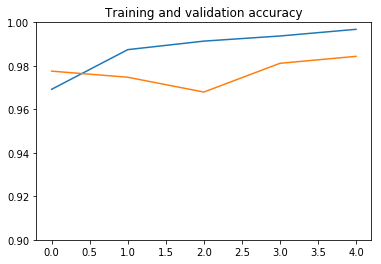

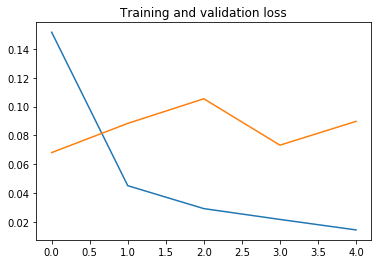

In [54]:
plot_history(history, yrange=(0.9,1))

We see that the model is very fast to train, as we just need to train the classifier part. One epoch is actually enough to reach a validation accuracy of about 98%, much higher than the 92% we got when we trained a simple convolutional network from scratch on our own in [Image Recognition: Dogs vs Cats!](https://thedatafrog.com/dogs-vs-cats/).  

After that, the accuracy plateaus. Overfitting is moderate and is limiting performance. We could probably work on overfitting by simplifying the classifier, or by adding a dropout layer just before the classifier. But this is out of scope for this post. 


## A brief digression about statistical uncertainty

Note that value of the accuracy should not be taken too seriously. The validation accuracy depends on the specific validation sample that has been chosen by the generator, and this number is affected by statistical uncertainty. Roughly speaking, we have 2500 images in the validation dataset. An inaccuracy of 2% means that we misclassify 50 images. 

Since this number is fairly small, it is affected by fairly large statistical uncertainty. And we can estimate the relative uncertainty on this number as $1/\sqrt{50} \sim 15\%$. The _relative_ uncertainty on the inaccuracy is also of the order of 15%. So for a 2% inaccuracy, we have an absolute uncertainty of 2 x 0.15 = 0.3%. 

Therefore, when we talk about a 98% accuracy, you should remember that the true accuracy should within $98 \pm 0.3\%$. 

We could use a larger validation dataset to reduce the uncertainty, but this would leave less images for the training of our neural networks. 


## VGG19 

VGG19 is the most recent version of the VGG models and is very similar to VGG16. If you compare the model summary below to the one of VGG16, you will see that the architecture is the same, and is still based on five convolutional blocks. 

However, the depth of the network has been further increased by adding a convolutional layer in the last three blocks.

The input is still an RGB image of shape (224,224,3), and the output a feature tensor of shape (7,7,512). Keras provides a specific preprocessing function for VGG19, but if you look at the code, you'll see that it's the exact same function as for VGG 16. So we don't need to redefine our dataset iterators.

Now let's build and check the full model: 

In [55]:
vgg19 = keras.applications.vgg19
conv_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers: 
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [56]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,
)

Epoch 1/5
750/750 [==============================] - 81s 107ms/step - loss: 0.1766 - acc: 0.9705 - val_loss: 0.0685 - val_acc: 0.9816
Epoch 2/5
750/750 [==============================] - 80s 107ms/step - loss: 0.0496 - acc: 0.9864 - val_loss: 0.0683 - val_acc: 0.9816
Epoch 3/5
750/750 [==============================] - 81s 108ms/step - loss: 0.0329 - acc: 0.9908 - val_loss: 0.0661 - val_acc: 0.9792
Epoch 4/5
750/750 [==============================] - 81s 108ms/step - loss: 0.0254 - acc: 0.9938 - val_loss: 0.0793 - val_acc: 0.9808
Epoch 5/5
750/750 [==============================] - 81s 108ms/step - loss: 0.0156 - acc: 0.9959 - val_loss: 0.0669 - val_acc: 0.9856


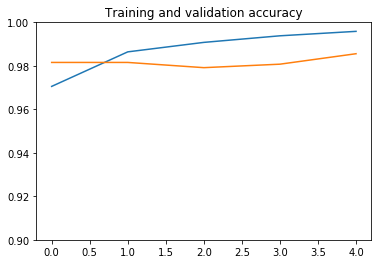

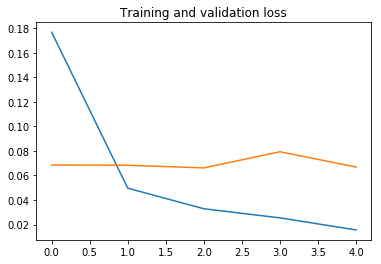

In [57]:
plot_history(history, yrange=(0.9,1))

## ResNet50

**Short intro to ResNet50**

In [4]:
resnet50 = keras.applications.resnet50

train_dataset, val_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 22481 images belonging to 2 classes.
Found 2496 images belonging to 2 classes.


In [5]:

conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

/opt/deeplearning/anaconda2/envs/maldives3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,
)

Epoch 1/5
750/750 [==============================] - 65s 87ms/step - loss: 0.1596 - acc: 0.9601 - val_loss: 0.0497 - val_acc: 0.9856
Epoch 2/5
750/750 [==============================] - 62s 83ms/step - loss: 0.0587 - acc: 0.9800 - val_loss: 0.0562 - val_acc: 0.9828
Epoch 3/5
750/750 [==============================] - 62s 83ms/step - loss: 0.0365 - acc: 0.9874 - val_loss: 0.0720 - val_acc: 0.9828
Epoch 4/5
750/750 [==============================] - 62s 83ms/step - loss: 0.0294 - acc: 0.9908 - val_loss: 0.0921 - val_acc: 0.9800
Epoch 5/5
750/750 [==============================] - 63s 84ms/step - loss: 0.0235 - acc: 0.9921 - val_loss: 0.0625 - val_acc: 0.9824


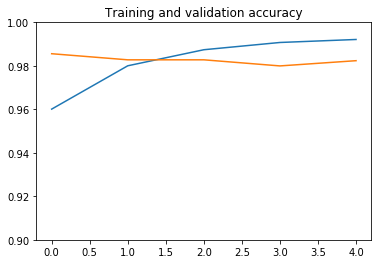

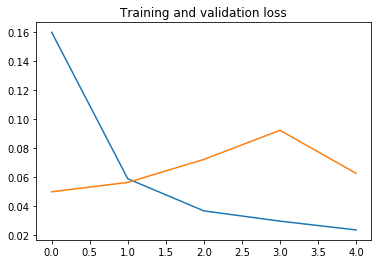

In [7]:
plot_history(history, yrange=(0.9,1))

## Saving and loading a Keras model

Let's say you obtained excellent performance with a given model. You certainly want to save this model for future use. Let's do this now with our model based on InceptionV3, which is the last one we have trained. 

With Keras, it's possible to make the full model persistent on disk, but the models might become unreadable when non-standard layers are used. 

I find saving only the model weights (parameters) easier: 

In [8]:
full_model.save_weights('resnet50.h5')

To read them again, we create a new model, identical to the one we have trained: 

In [9]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

And load the weights: 

In [10]:
full_model.load_weights('resnet50.h5')

## Model evaluation

Now that the model is loaded, we can evaluate a single image: 

Using TensorFlow backend.


[[9.9999690e-01 3.1462735e-06]]


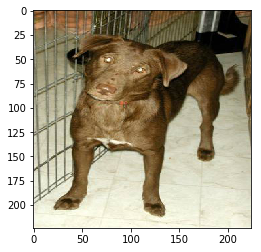

In [11]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

img_path = 'dogs/dog.1.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(full_model.predict(x))
plt.imshow(img)

Our neural network gives this image a 99.9997% probability. That's actually not too surprising: this is an archetypal dog, so no difficulty here. 

But what about other images in the dataset? It would be very interesting to look at misidentified images, to see what's going on with them. Let's start by evaluating the model for all images in the **training** dataset: 

In [57]:
import sys

def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,2))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = full_model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

labels, preds = true_and_predicted_labels(train_dataset)

Now that we have the model predictions, we can illustrate how the model is able to separate the two categories. For this, we will consider only the cat score, remembering that the dog score is equal to one minus the cat score. And we will plot the cat score for the two categories. For cats, we expect the cat score to be close to one. For dogs, it will be close to zero. 

In [58]:
def plot_cat_score(preds, range=(0,1)):
    # get the cat score for all images
    cat_score = preds[:,1]
    # get the cat score for dogs
    # we use the true labels to select dog images
    dog_cat_score = cat_score[labels[:,0]>0.5]
    # and for cats
    cat_cat_score = cat_score[labels[:,0]<0.5]
    # just some plotting parameters
    params = {'bins':100, 'range':range, 'alpha':0.6}
    plt.hist(dog_cat_score, **params)
    plt.hist(cat_cat_score, **params)
    plt.yscale('log')

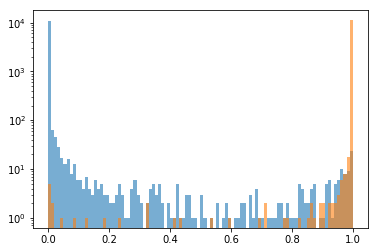

In [59]:
plot_cat_score(preds)

Please note that I have used a log scale on the y axis. I did this because, with this excellent classification accuracy, we end up with most pictures having either a cat score very close to 1 (clear cats), or very close to 0 (clear dogs), such as the example we plotted above. In the middle, we see the more difficult cases.

We can now compute the accuracy. 

For this we need to compute the predicted labels and compare them with the true labels. 
To compute the predicted labels, we take the cat score, and we decide that the network predicts a cat if this score is larger than a given threshold. 

Keras provides an estimation of the accuracy during the training. For this estimation, keras uses a threshold of 0.5, so let's do that as well: 

In [60]:
threshold = 0.5

def predicted_labels(preds, threshold):
    '''Turn predictions (floats in the last two dimensions) 
    into labels (0 or 1).'''
    pred_labels = np.zeros_like(preds)
    # cat score lower than threshold: set dog label to 1
    # cat score higher than threshold: set dog label to 0
    pred_labels[:,0] = preds[:,1]<threshold
    # cat score higher than threshold: set cat label to 1
    # cat score lower than threshold: set cat label to 0
    pred_labels[:,1] = preds[:,1]>=threshold
    return pred_labels

pred_labels = predicted_labels(preds, threshold)
print('predicted labels:')
print(pred_labels)
print('true labels:')
print(labels)

predicted labels:
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
true labels:
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


We see that the predicted labels seem to be very similar to the true labels. This is because the accuracy is close to 100%, and only a few examples are shown in the printout above. Let's quantify the fraction of misclassified examples: 

In [61]:

def misclassified(labels, pred_labels, print_report=True):
    n_examples = len(labels)
    def report(categ, array): 
        n_misclassified = len(array)
        print('{:<4} {:>3} misclassified samples ({:4.2f}%)'.format(
            categ,
            n_misclassified, 
            100*float(n_misclassified)/n_examples)
        )
    n_examples = len(labels)
    mask_all = pred_labels[:,0] != labels[:,0]
    mask_cats = np.logical_and(mask_all,labels[:,1]>0.5)
    mask_dogs = np.logical_and(mask_all,labels[:,1]<0.5)
    misc_all = labels[mask_all]
    misc_cats = labels[mask_cats]
    misc_dogs = labels[mask_dogs]
    if print_report:
        report('all', misc_all)
        report('cats', misc_cats)
        report('dogs', misc_dogs)
    return mask_all, mask_cats, mask_dogs

_ = misclassified(labels, pred_labels)

all  154 misclassified samples (0.69%)
cats  16 misclassified samples (0.07%)
dogs 138 misclassified samples (0.61%)


With my training, we see that the dogs are much more difficult to classify. However, each training could lead to different results. I did a few, and I got symmetric classification performance only once. 

Now, is there a reason to pick a threshold at 0.5 for classification? Let's plot the cat score again:

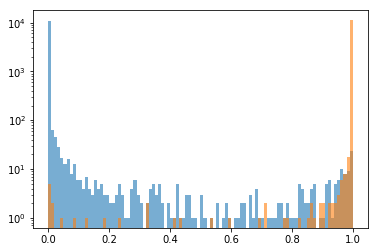

In [62]:
plot_cat_score(preds)

Clearly, with a threshold of 0.95 or so, we are only going to misclassify a few more cats, but we will gain a lot of dogs. Let's try: 

In [63]:
threshold = 0.95
pred_labels = predicted_labels(preds, threshold)
_ = misclassified(labels, pred_labels)

all   95 misclassified samples (0.42%)
cats  38 misclassified samples (0.17%)
dogs  57 misclassified samples (0.25%)


With this choice of threshold, we improve the global classification accuracy from 100-0.69 = 99.31% to 100-0.42=99.58%. This is a large gain at this stage!

So remember: 

---

**Always check the classification score and tune your threshold properly.**

---

Now, we optimized the threshold on the training dataset. What do we get with the validation dataset? 

In [64]:
labels, preds = true_and_predicted_labels(val_dataset)
pred_labels = predicted_labels(preds, threshold)
_ = misclassified(labels, pred_labels)

all   35 misclassified samples (1.40%)
cats  14 misclassified samples (0.56%)
dogs  21 misclassified samples (0.84%)


Here also, the classification is rather symmetric, and the validation accuracy is 98.6%. With a classification threshold at 0.5, we would get:

In [65]:
pred_labels = predicted_labels(preds, 0.5)
_ = misclassified(labels, pred_labels)

all   42 misclassified samples (1.68%)
cats   8 misclassified samples (0.32%)
dogs  34 misclassified samples (1.36%)


So the classification accuracy improved from 98.32% to 98.6%

## Looking at misclassified pictures

There is a slight issue in the interface of the `ImageDataGenerator`: it does not allow us to find back the images that are misclassified, so that we could load them from disk and look at them. So we need to evaluate again the network again, storing the misidentified images for later display. 

In [86]:
import sys

dataset = val_dataset
misclassified_imgs = dict(dogs=[], cats=[])
for i in range(len(dataset)):
    if i%100: 
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
    batch = dataset[i]
    batch_images = batch[0]
    batch_labels = batch[1]
    batch_preds = full_model.predict(batch_images)
    batch_pred_labels = predicted_labels(batch_preds, threshold=0.95)
    mask_all, mask_cats, mask_dogs = misclassified(
        batch_labels, 
        batch_pred_labels,
        print_report=False                                  
    )
    misclassified_imgs['dogs'].extend(batch_images[mask_dogs])
    misclassified_imgs['cats'].extend(batch_images[mask_cats])

Here is the number of misclassified images in each category:

In [87]:
print([(label, len(imgs)) for label,imgs in misclassified_imgs.items()])

[('dogs', 20), ('cats', 16)]


You have certainly noticed that these numbers do not correspond exactly to the ones we have seen above (14 misclassified cats and 21 misclassified dogs). I think this might be due to some amount of randomness in the evaluation of the network, or to numerical precision, and I have no idea where this is coming from.

Now let's write a small function to plot a bunch of images, so that we can have a look at the misclassified images:

In [88]:
def plot_images(imgs, i):
    ncols, nrows = (5, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

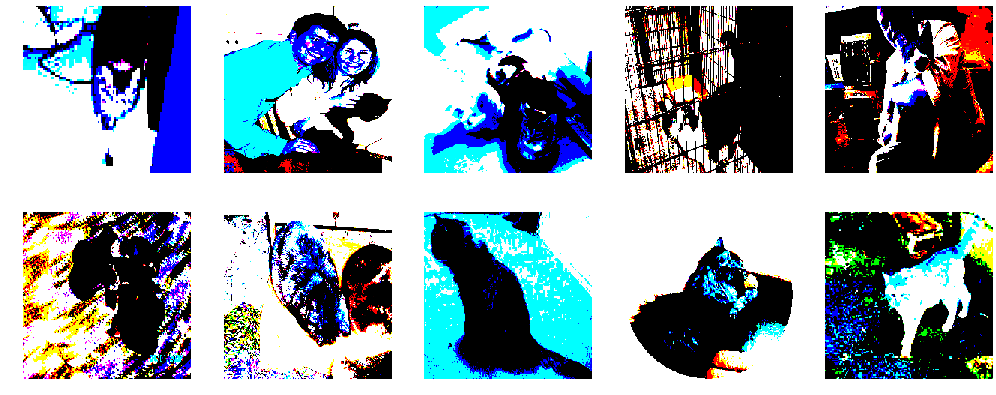

In [89]:
plot_images(misclassified_imgs['cats'],0)

Wow what's this?? the colors are completely messed up... 

This is due to the image preprocessing performed by the dataset iterator. Remember that we're using ResNet50 and that have requested our images to be preprocessed with `keras.applications.resnet50.preprocess_input`. Do we have a way to undo this operation? For that we first need to find this function to understand what it is doing. 

We start by checking our version of `keras_applications`:

In [90]:
import keras_applications
keras_applications.__version__

'1.0.8'

Then we look at the source code of `resnet50` and we see that [this function](https://github.com/keras-team/keras-applications/blob/1.0.8/keras_applications/resnet50.py#L22) is taken from `imagenet_utils`, where it is defined [here](https://github.com/keras-team/keras-applications/blob/1.0.8/keras_applications/imagenet_utils.py#L157). 

We're calling the function without any argument apart from the image to be preprocessed. So we're in `"caffe"` mode. Also, we are providing a numpy array to the function, so we are actually calling `_preprocess_numpy_input`, [here](https://github.com/keras-team/keras-applications/blob/1.0.8/keras_applications/imagenet_utils.py#L21).

In the caffe mode, the function is doing the following:

* switch from the RGB color representation to BGR
* subtract the mean BGR values calculated for the whole ImageNet dataset to center the BGR values on 0

We can easily write a function to undo this operation: 

In [120]:
def undo_preprocessing(x):
    mean = [103.939, 116.779, 123.68]
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    x = x[..., ::-1]


Our function first adds back the mean of the BGR values, since this was the last operation of the preprocessing. And then we revert again the order of the color levels. What might not be obvious to you is the last line, which reverts the order of the color levels. So let's have a look in details. 

* the notation `...` means: add as many operations as necessary. So we're going to leave the first dimensions of the images untouched, to act only on the last dimension, the one of the color levels (please note that  I'm using keras in channels last mode). 
* the notation `::-1` acts on the last dimension, and revert the order of the numbers there. 

Let's take a simple example. We build an array with shape (2,2,3). You can think of it as an image with 2x2 pixels and 3 color levels:

In [145]:
a = np.arange(12).reshape(2,2,3)
print(a)

[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]]


In the top left pixel, the three color levels are set to `[0 1 2]` respectively, and in the bottom right pixel to `[9 10 11]`. We can see that the reverting operation has the expected effect: 

In [146]:
a[...,::-1]

array([[[ 2,  1,  0],
        [ 5,  4,  3]],

       [[ 8,  7,  6],
        [11, 10,  9]]])

Now let's try our unprocessing function on one image: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


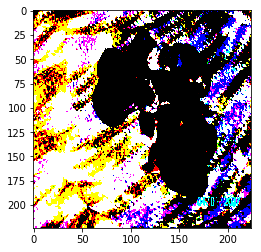

In [148]:
img = misclassified_imgs['cats'][5]
plt.imshow(img)

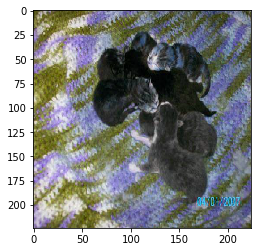

In [150]:
import copy
new_img = copy.copy(img)
undo_preprocessing(new_img)
plt.imshow(new_img.astype('int'))

Much better! The function seems to work as expected.  So we modify our plotting function to plot unprocessed images: 

In [151]:
def plot_images(imgs, i):
    ncols, nrows = (5, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        img_unproc = copy.copy(img)
        undo_preprocessing(img_unproc)
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img_unproc.astype('int'))
        plt.axis('off')

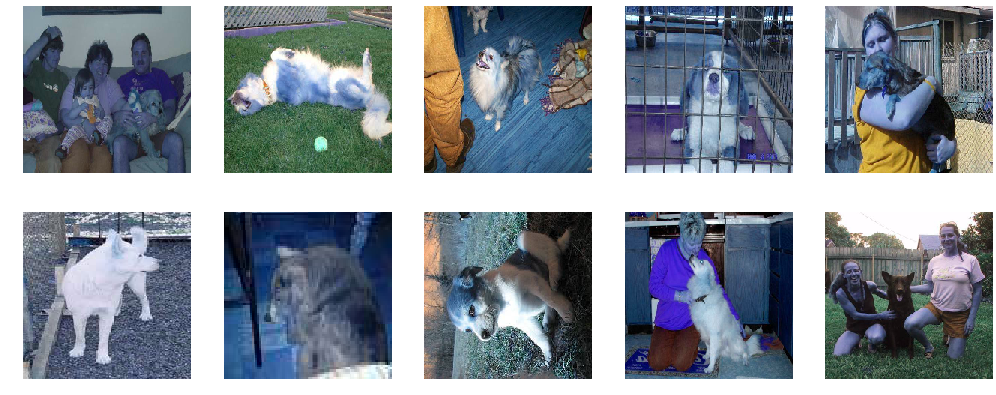

In [155]:
plot_images(misclassified_imgs['dogs'],0)

Actually the colors still look a bit funny... I don't really know why and being colorblind, I'm not completely sure! Anyway, we can at least understand the images now. 

We can try to guess why these images were misclassified. It could be that cats are more often carried by people, which would bias the network towards misclassifying dogs when people are in the image. Also, the wrong orientation of one image probably does not help. Then, cats often sleep on their back, while this position is not that common for dogs. Finally, the cage in the fourth picture is certainly challenging.